In [1]:
from matplotlib import pyplot as plt
from settings import config
from pathlib import Path
DATA_DIR = config("DATA_DIR")
OUTPUT_DIR = config("OUTPUT_DIR")
START_DATE = config("START_DATE")
END_DATE = config("END_DATE")
PAPER_END_DATE = config("PAPER_END_DATE")
from pull_bloomberg import pull_bbg_data

In [2]:
df= pull_bbg_data(START_DATE,END_DATE)

In [3]:
df.head()

,SPX Index,SX5E Index,NKY Index,USGG30YR Index,GDBR30 Index,GJGB30 Index
Date,,,,,,
2020-01-01,NaN,NaN,NaN,2.3896,0.349,0.425
2020-01-02,3257.85,3793.24,NaN,2.3312,0.307,0.425
2020-01-03,3234.85,3773.37,NaN,2.2444,0.251,0.425
2020-01-06,3246.28,3752.52,23204.86,2.2858,0.249,0.411
2020-01-07,3237.18,3759.25,23575.72,2.3052,0.256,0.440


In [4]:
from clean_data import clean_bbg_data
bbg_df_cleaned = clean_bbg_data(PAPER_END_DATE, DATA_DIR)
bbg_df_cleaned.head()

,SPX Index,SX5E Index,NKY Index,USGG30YR Index,GDBR30 Index,GJGB30 Index
Date,,,,,,
2020-01-01,NaN,NaN,NaN,2.3896,0.349,0.425
2020-01-02,3257.85,3793.24,NaN,2.3312,0.307,0.425
2020-01-03,3234.85,3773.37,NaN,2.2444,0.251,0.425
2020-01-06,3246.28,3752.52,23204.86,2.2858,0.249,0.411
2020-01-07,3237.18,3759.25,23575.72,2.3052,0.256,0.440


In [5]:
from calc_functions import calc_pct_returns
returns = calc_pct_returns(DATA_DIR)
import pandas as pd

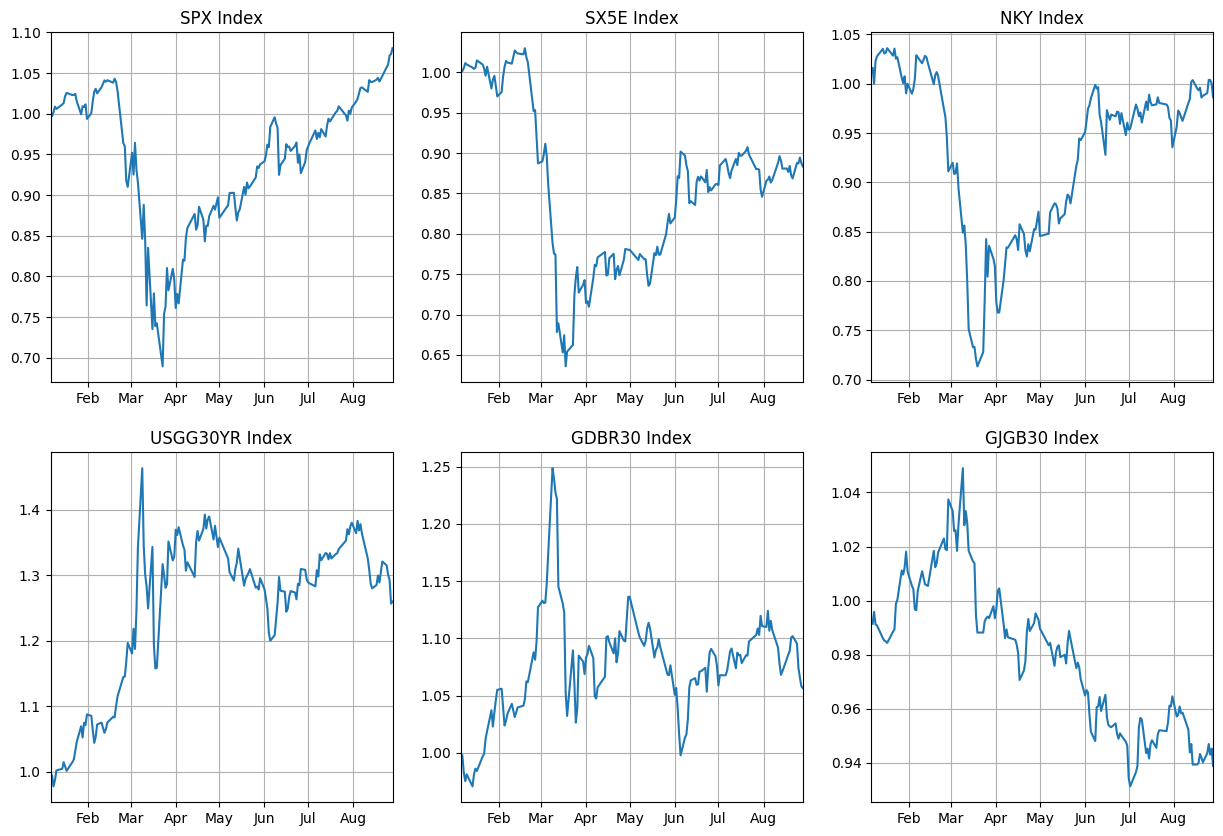

In [6]:

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  # 2 rows, 3 columns

# Flatten axes for easy iteration
axes = axes.flatten()

for i, col in enumerate(returns.columns):
    # Plot the data
    axes[i].plot(returns.index, returns[col], label=col)
    axes[i].set_title(col)
    
    # 1) Set the x-axis to start at the first date and end at the last date in returns
    axes[i].set_xlim([returns.index[0], returns.index[-1]])
    
    # 2) Generate ticks at the start of each month (MS = Month Start)
    xticks = pd.date_range(start=returns.index[0], end=returns.index[-1], freq="MS")
    
    # 3) Apply those ticks and label them with three-letter month abbreviations
    axes[i].set_xticks(xticks)
    axes[i].set_xticklabels([x.strftime("%b") for x in xticks])
    
    # Add grid
    axes[i].grid()